In [1]:
import gymnasium as gym
import aero_gym
import math
import numpy as np
from gymnasium.utils.env_checker import check_env
from gymnasium.wrappers import FrameStack, FlattenObservation
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# Evaluate function for continuous actions only
def evaluate(env, filename, a_ddot_prescribed=None):
    writefile = open(filename, "w")
    env.reset()
    done = False
    i = 0
    while 1:
        if a_ddot_prescribed is None:
            action = [0.0]
        else:
            action = [a_ddot_prescribed[i]]

        writestr = env.render()
        obs, reward, terminated, truncated, info = env.step(action)
        writestr += (" {:10.3e}"*2).format(*action, info["previous fy"])
        writefile.write(writestr + "\n")
        i+=1
        if terminated or truncated:
            break
    writefile.close()
    return obs, info

In [5]:
def plotfile(filename, axarr=None, label='', a=0):
    if axarr is None:
        fig, axarr = plt.subplots(ncols=3, nrows=2, figsize=(17,7))
    else:
        fig = axarr[0,0].figure
    axarr[0,0].set_ylabel('total lift')
    axarr[0,1].set_ylabel('h dot')
    axarr[0,2].set_ylabel('h ddot')
    axarr[1,0].set_ylabel('alpha')
    axarr[1,1].set_ylabel('alpha dot')
    axarr[1,2].set_ylabel('alpha ddot')

    with open(filename, "r") as readFile:
        textstr = readFile.readlines()
        all_lines = [line.split() for line in textstr]
        t_hist = [float(x[1]) for x in all_lines]
        h_dot_list = [float(x[2]) for x in all_lines]
        alpha_list = [float(x[3]) for x in all_lines]
        alpha_dot_list = [float(x[4]) for x in all_lines]
        alpha_eff_list = [float(x[5]) for x in all_lines]
        h_ddot_list = [float(x[6]) for x in all_lines]
        alpha_ddot_list = [float(x[7]) for x in all_lines]
        fy_hist = [float(x[8]) for x in all_lines]
        am_list = [math.pi / 4 * (-h_ddot_list[i] - a * alpha_ddot_list[i] + alpha_dot_list[i]) for i in range(len(h_ddot_list))]
        axarr[0,0].plot(t_hist,fy_hist,label=label, marker='o', markersize=2, linewidth=1)
        axarr[0,1].plot(t_hist,h_dot_list, marker='o', markersize=2, linewidth=1, label=(label + " (a = " + str(a)))
        axarr[0,2].plot(t_hist,h_ddot_list, marker='o', markersize=2, linewidth=1)
        axarr[1,0].plot(t_hist,alpha_list, marker='o', markersize=2, linewidth=1)
        axarr[1,1].plot(t_hist,alpha_dot_list, marker='o', markersize=2, linewidth=1)
        axarr[1,2].plot(t_hist,alpha_ddot_list, marker='o', markersize=2, linewidth=1)
        readFile.close()

    axarr[0,0].legend()
    for ax in axarr.flatten():
        ax.minorticks_on()
        ax.grid(which='both',axis='y')
        ax.set_xlabel('time')
    return fig, axarr

In [6]:
t_max = 20
delta_t = 0.1
t = np.linspace(0, t_max, int(t_max/delta_t)+1)

In [7]:
h_ddot_impulse = np.zeros(len(t))
h_ddot_impulse[0] = 1.0
h_ddot_ones = np.ones(len(t))
h_ddot_binary_periodic = (np.sin(t) > 0).astype(int) - 0.01*(np.sin(t) < 0).astype(int)

## Impulse

In [6]:
env = gym.make(
    'aero_gym/wagner-v0', 
    render_mode="ansi", 
    t_max=t_max, 
    delta_t=delta_t, 
    h_ddot_prescribed=h_ddot_impulse,
    use_discretized_wake=True,
    observe_alpha_eff=True,
    reward_type=3,
    observe_previous_circulatory_pressure=True,
    pressure_sensor_positions=[0.0])
env_jones = gym.make(
    'aero_gym/wagner-v0', 
    render_mode="ansi", 
    t_max=t_max, 
    delta_t=delta_t, 
    h_ddot_prescribed=h_ddot_impulse,
    observe_alpha_eff=True,
    reward_type=3)

In [7]:
env.observation_space

Box(-inf, inf, (4,), float32)

In [8]:
env.reset()
env.step([0.0])

(array([ 0.  ,  0.  , -0.05,  0.  ], dtype=float32),
 0.6073009183012759,
 False,
 False,
 {'previous fy': -0.39269908169872414,
  'previous alpha_ddot': 0.0,
  'current alpha_dot': 0.0,
  'current alpha_eff': -0.05000000000000001,
  'current h_ddot': 0.0,
  'current t': 0.1,
  'current time_step': 1})

In [9]:
check_env(env.unwrapped)

/u/home/b/beckers/unsteady_aero_RL/gymnasium_28/env_gymnasium_28/lib/python3.9/site-packages/gymnasium/utils/env_checker.py:221: UserWarning: WARN: A Box observation space minimum value is -infinity. This is probably too low.
  logger.warn(
/u/home/b/beckers/unsteady_aero_RL/gymnasium_28/env_gymnasium_28/lib/python3.9/site-packages/gymnasium/utils/env_checker.py:225: UserWarning: WARN: A Box observation space maximum value is -infinity. This is probably too high.
  logger.warn(


In [10]:
obs, info = evaluate(env, 'testlog_impulse.txt')
obs_jones, info_jones = evaluate(env_jones, 'testlog_impulse_jones.txt')

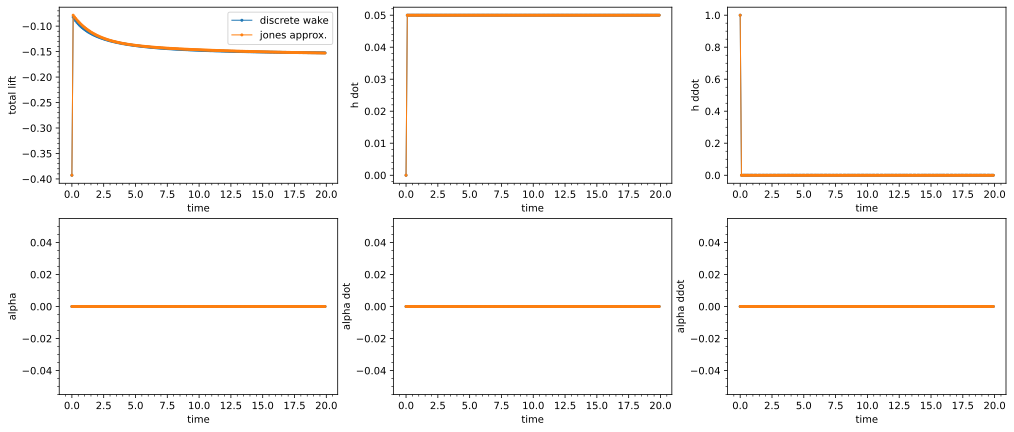

In [11]:
%config InlineBackend.figure_format = 'svg'
fig, axarr = plotfile('testlog_impulse.txt', label='discrete wake')
fig, axarr = plotfile('testlog_impulse_jones.txt', axarr=axarr, label='jones approx.')

## Step

In [12]:
env = gym.make(
    'aero_gym/wagner-v0', 
    render_mode="ansi", 
    t_max=t_max, 
    delta_t=delta_t, 
    use_discretized_wake=True,
    h_ddot_prescribed=h_ddot_ones,
    reward_type=3)
env_jones = gym.make(
    'aero_gym/wagner-v0', 
    render_mode="ansi", 
    t_max=t_max, 
    delta_t=delta_t, 
    h_ddot_prescribed=h_ddot_ones,
    reward_type=3)

In [13]:
obs, info = evaluate(env, 'testlog_ones.txt')
obs, info = evaluate(env_jones, 'testlog_ones_jones.txt')

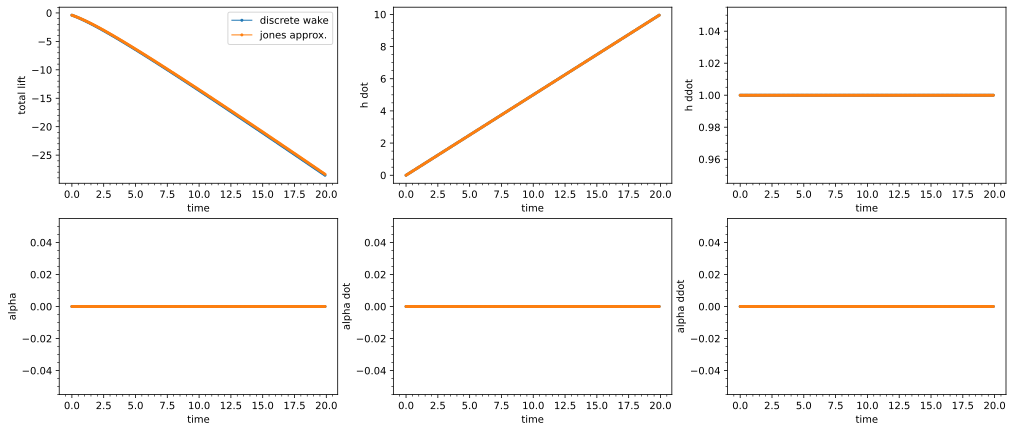

In [14]:
%config InlineBackend.figure_format = 'svg'
fig, axarr = plotfile('testlog_ones.txt', label='discrete wake')
fig, axarr = plotfile('testlog_ones_jones.txt', axarr=axarr, label='jones approx.')

## Gaussian

In [15]:
def gaussian(x, a, b, c):
    return a * math.exp(-(x - b) ** 2 / (2 * c ** 2))

def dgaussian(x, a, b, c):
    return a * -(x - b) / c ** 2 * math.exp(-(x - b) ** 2 / (2 * c ** 2))

def ddgaussian(x, a, b, c):
    return a * (x ** 2 + b ** 2 - 2 * b * x - c ** 2) / c ** 4 * math.exp(-(x - b) ** 2 / (2 * c ** 2))

In [16]:
a = -2/3
b = 3.0
c = 0.4
h_ddot_dgaussian = [dgaussian(ti, a, b, c) for ti in t]

a = 1/6
b = 15.0
c = 0.4
alpha_ddot_dgaussian = [ddgaussian(ti, a, b, c) for ti in t]

In [17]:
env = gym.make(
    'aero_gym/wagner-v0', 
    render_mode="ansi", 
    t_max=t_max, 
    delta_t=delta_t, 
    use_discretized_wake=True,
    h_ddot_prescribed=h_ddot_dgaussian,
    reward_type=3,
    observe_alpha_eff=True)
env_jones = gym.make(
    'aero_gym/wagner-v0', 
    render_mode="ansi", 
    t_max=t_max, 
    delta_t=delta_t, 
    h_ddot_prescribed=h_ddot_dgaussian,
    reward_type=3,
    observe_alpha_eff=True)

In [18]:
obs, info = evaluate(env, 'testlog_gaussian.txt', a_ddot_prescribed=alpha_ddot_dgaussian)
obs, info = evaluate(env_jones, 'testlog_gaussian_jones.txt', a_ddot_prescribed=alpha_ddot_dgaussian)

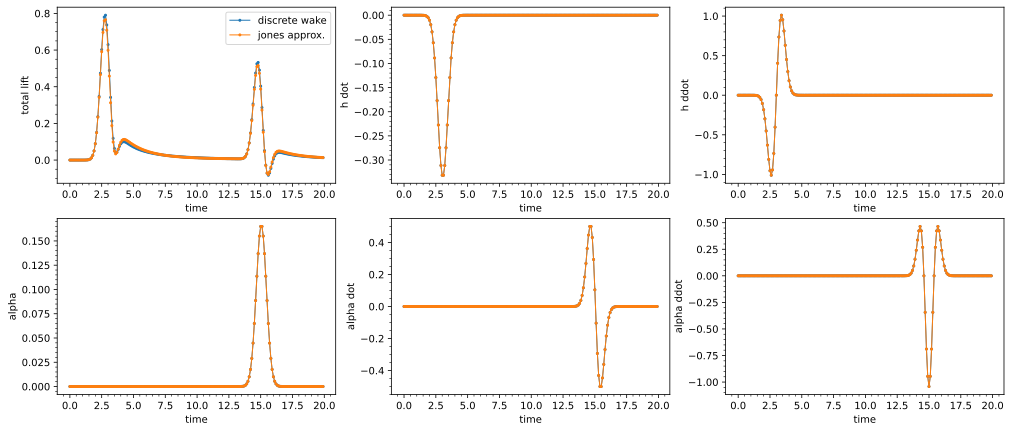

In [19]:
%config InlineBackend.figure_format = 'svg'
fig, axarr = plotfile('testlog_gaussian.txt', label='discrete wake')
fig, axarr = plotfile('testlog_gaussian_jones.txt', axarr=axarr, label='jones approx.')

## Test h_ddot_generators

In [20]:
import sys
sys.path.append('../aero_gym_SB3/')
import h_ddot_generators

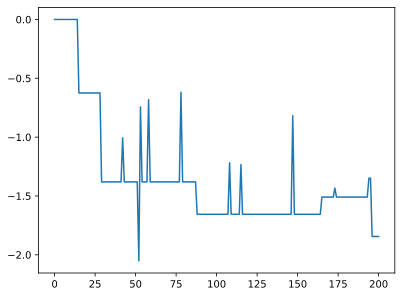

In [21]:
h_ddot = h_ddot_generators.random_steps_ramps(env)
plt.plot(h_ddot)